# 570 Group Project

# Introdcue

## The Purpose of The Project
### We want to find the fitting model to predict vehicle loan default and predict the customer who will default for paying the Equated Monthly Instalments.

## The Meaning or Benefit of The Project
### The high default rate of vehicle loans led to restrict the vehicle loan and increased vehicle loan rejection rates. At the meantime, the financial institutions have a significant losses due to the less vehicle loans. It is meaningful to have a better credit risk scoring model. We want to accurately predict the probability of borrower defaulting on a vehicle loan in the first Equated Monthly Instalments.

## The literature review
### Shu Yang, Yang Qiuyi made the research on Auto Loan Default Prediction Based on Large Sample Data Model. They used ROC curves to test the efficiency of Stepwise Regression, then respectively applies Binary Choice Model and Count Model to predict the default status of loan customers. And they finally concludes that balanced sample after matching still possesses superior prediction accuracy rate, that Logistic Model is the most suitable when companies intend to predict whether a customer will default, and that Negative Binomial Model has better efficiency if companies need to know the time length of a customer not paying back.
### KASHYAP NARAYAN made the research on L&T Vehicle Loan Default Prediction, he think the best model is Random Forest Classifier with SMOTE. Compared to Logistic Regression, it is overfitting a seen from AUC scores. However, it also shows good F1-score(1), slightly lower than Logistic Regression. It has a better(lower) binary log loss, when compared to Logistic Regression.

# So we decide to use 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
from sklearn.impute import KNNImputer
from numpy import isnan
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

In [3]:
#Set seed for check and compare purpose
np.random.seed(42)

# Data
## We got the dataset for vehicle loan default prediction from Kaggle. These database are split to training data and testing data to evulate our models.

In [4]:
data = pd.read_csv('train_data.csv')
data

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,555299,41394,75208,57.17,255,23415,45,5829,14/02/1968,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,611197,64213,87691,74.12,19,14375,86,1876,15/07/1987,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
2,433544,73423,98158,76.31,67,21308,86,1435,02/06/1994,Salaried,...,0,0,0,0,0,0,2yrs 1mon,2yrs 1mon,0,0
3,648093,53146,63841,88.97,79,17507,45,738,14/06/1974,Self employed,...,0,0,0,0,1,0,0yrs 0mon,0yrs 0mon,0,0
4,461365,54113,66542,83.41,18,22832,45,2708,08/08/1979,Salaried,...,0,0,2426,0,0,0,1yrs 0mon,1yrs 6mon,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174860,478886,56651,68697,85.00,3,15513,86,14,29/09/1965,Self employed,...,800000,800000,162256,0,2,3,1yrs 6mon,3yrs 1mon,0,0
174861,485393,49608,58466,88.94,61,15897,45,1323,09/05/1961,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
174862,503503,47145,65439,74.88,48,23601,45,6296,01/01/1972,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
174863,618661,50578,73000,71.23,248,14791,45,1787,21/01/1983,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0


In [5]:
dataTest = pd.read_csv('test_data.csv')
dataTest

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES
0,605959,58259,73838,79.90,146,17921,86,2970,01/01/1986,Self employed,...,0,0,0,0,0,0,0,1yrs 6mon,3yrs 4mon,0
1,455801,49558,71644,72.58,20,22882,86,6181,04/05/1976,Salaried,...,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0
2,437173,42710,67681,65.01,251,20514,45,6863,01/10/1981,Self employed,...,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0
3,565974,80233,96523,84.95,138,20470,86,3366,17/05/1978,Self employed,...,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0
4,504124,46549,62590,79.88,74,16846,45,2610,23/07/1987,Salaried,...,0,0,0,0,0,2,0,0yrs 3mon,0yrs 7mon,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58284,544324,47899,59400,82.15,15,14441,45,295,01/01/1983,Salaried,...,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0
58285,590377,54513,67399,83.09,67,16640,45,1461,21/11/1976,Salaried,...,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0
58286,583011,63947,72360,89.83,62,16739,45,383,01/01/1980,Self employed,...,0,0,0,5440,0,1,0,0yrs 11mon,2yrs 0mon,1
58287,549585,53803,67774,81.15,18,14234,86,2694,29/12/1979,Self employed,...,0,0,0,3617,0,2,1,3yrs 9mon,10yrs 7mon,3


In [6]:
data = pd.concat([data,dataTest],ignore_index = True)
'''
Keep UniqueID to the last step in order to seperate train and test!!
'''
data

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,555299,41394,75208,57.17,255,23415,45,5829,14/02/1968,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0.0
1,611197,64213,87691,74.12,19,14375,86,1876,15/07/1987,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0.0
2,433544,73423,98158,76.31,67,21308,86,1435,02/06/1994,Salaried,...,0,0,0,0,0,0,2yrs 1mon,2yrs 1mon,0,0.0
3,648093,53146,63841,88.97,79,17507,45,738,14/06/1974,Self employed,...,0,0,0,0,1,0,0yrs 0mon,0yrs 0mon,0,0.0
4,461365,54113,66542,83.41,18,22832,45,2708,08/08/1979,Salaried,...,0,0,2426,0,0,0,1yrs 0mon,1yrs 6mon,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233149,544324,47899,59400,82.15,15,14441,45,295,01/01/1983,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,NaN
233150,590377,54513,67399,83.09,67,16640,45,1461,21/11/1976,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,NaN
233151,583011,63947,72360,89.83,62,16739,45,383,01/01/1980,Self employed,...,0,0,5440,0,1,0,0yrs 11mon,2yrs 0mon,1,NaN
233152,549585,53803,67774,81.15,18,14234,86,2694,29/12/1979,Self employed,...,0,0,3617,0,2,1,3yrs 9mon,10yrs 7mon,3,NaN


In [7]:
data.columns

Index(['UniqueID', 'disbursed_amount', 'asset_cost', 'ltv', 'branch_id',
       'supplier_id', 'manufacturer_id', 'Current_pincode_ID', 'Date.of.Birth',
       'Employment.Type', 'DisbursalDate', 'State_ID', 'Employee_code_ID',
       'MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag',
       'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'PERFORM_CNS.SCORE.DESCRIPTION', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
       'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
       'loan_default'],
      dtype='object')

## Data Cleaning

In [8]:
#First mannually drop some useless features
data = data.drop(['branch_id','supplier_id','manufacturer_id','Current_pincode_ID','State_ID','Employee_code_ID'],axis = 1)
data

,UniqueID,disbursed_amount,asset_cost,ltv,Date.of.Birth,Employment.Type,DisbursalDate,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,555299,41394,75208,57.17,14/02/1968,Self employed,03/10/2018,1,1,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0.0
1,611197,64213,87691,74.12,15/07/1987,Self employed,24/10/2018,1,1,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0.0
2,433544,73423,98158,76.31,02/06/1994,Salaried,11/08/2018,1,0,0,...,0,0,0,0,0,0,2yrs 1mon,2yrs 1mon,0,0.0
3,648093,53146,63841,88.97,14/06/1974,Self employed,31/10/2018,1,1,0,...,0,0,0,0,1,0,0yrs 0mon,0yrs 0mon,0,0.0
4,461365,54113,66542,83.41,08/08/1979,Salaried,24/08/2018,1,1,0,...,0,0,2426,0,0,0,1yrs 0mon,1yrs 6mon,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233149,544324,47899,59400,82.15,01/01/1983,Salaried,28/09/2018,1,1,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,NaN
233150,590377,54513,67399,83.09,21/11/1976,Salaried,20/10/2018,1,1,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,NaN
233151,583011,63947,72360,89.83,01/01/1980,Self employed,16/10/2018,1,1,0,...,0,0,5440,0,1,0,0yrs 11mon,2yrs 0mon,1,NaN
233152,549585,53803,67774,81.15,29/12/1979,Self employed,29/09/2018,1,1,0,...,0,0,3617,0,2,1,3yrs 9mon,10yrs 7mon,3,NaN


In [9]:
#Remove Column with single value
counts = data.nunique()
del_name = [i for i,v in enumerate(counts) if v == 1]
data[data.columns[del_name]]

,MobileNo_Avl_Flag
0,1
1,1
2,1
3,1
4,1
...,...
233149,1
233150,1
233151,1
233152,1


In [10]:
data.drop(data.columns[del_name],axis = 1,inplace = True)
data

,UniqueID,disbursed_amount,asset_cost,ltv,Date.of.Birth,Employment.Type,DisbursalDate,Aadhar_flag,PAN_flag,VoterID_flag,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,555299,41394,75208,57.17,14/02/1968,Self employed,03/10/2018,1,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0.0
1,611197,64213,87691,74.12,15/07/1987,Self employed,24/10/2018,1,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0.0
2,433544,73423,98158,76.31,02/06/1994,Salaried,11/08/2018,0,0,1,...,0,0,0,0,0,0,2yrs 1mon,2yrs 1mon,0,0.0
3,648093,53146,63841,88.97,14/06/1974,Self employed,31/10/2018,1,0,0,...,0,0,0,0,1,0,0yrs 0mon,0yrs 0mon,0,0.0
4,461365,54113,66542,83.41,08/08/1979,Salaried,24/08/2018,1,0,0,...,0,0,2426,0,0,0,1yrs 0mon,1yrs 6mon,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233149,544324,47899,59400,82.15,01/01/1983,Salaried,28/09/2018,1,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,NaN
233150,590377,54513,67399,83.09,21/11/1976,Salaried,20/10/2018,1,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,NaN
233151,583011,63947,72360,89.83,01/01/1980,Self employed,16/10/2018,1,0,0,...,0,0,5440,0,1,0,0yrs 11mon,2yrs 0mon,1,NaN
233152,549585,53803,67774,81.15,29/12/1979,Self employed,29/09/2018,1,0,0,...,0,0,3617,0,2,1,3yrs 9mon,10yrs 7mon,3,NaN


In [11]:
#Need to change datatype to integer or float or categorical to do following selection procedures
data.dtypes

UniqueID                                 int64
disbursed_amount                         int64
asset_cost                               int64
ltv                                    float64
Date.of.Birth                           object
Employment.Type                         object
DisbursalDate                           object
Aadhar_flag                              int64
PAN_flag                                 int64
VoterID_flag                             int64
Driving_flag                             int64
Passport_flag                            int64
PERFORM_CNS.SCORE                        int64
PERFORM_CNS.SCORE.DESCRIPTION           object
PRI.NO.OF.ACCTS                          int64
PRI.ACTIVE.ACCTS                         int64
PRI.OVERDUE.ACCTS                        int64
PRI.CURRENT.BALANCE                      int64
PRI.SANCTIONED.AMOUNT                    int64
PRI.DISBURSED.AMOUNT                     int64
SEC.NO.OF.ACCTS                          int64
SEC.ACTIVE.AC

In [12]:
DoB = copy.deepcopy(data['Date.of.Birth'])
for i in range(len(DoB)):
  DoB[i] = 2022 - int(DoB[i][6:])
DoB = DoB.astype(int)
data['Date.of.Birth'] = DoB
data

,UniqueID,disbursed_amount,asset_cost,ltv,Date.of.Birth,Employment.Type,DisbursalDate,Aadhar_flag,PAN_flag,VoterID_flag,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,555299,41394,75208,57.17,54,Self employed,03/10/2018,1,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0.0
1,611197,64213,87691,74.12,35,Self employed,24/10/2018,1,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0.0
2,433544,73423,98158,76.31,28,Salaried,11/08/2018,0,0,1,...,0,0,0,0,0,0,2yrs 1mon,2yrs 1mon,0,0.0
3,648093,53146,63841,88.97,48,Self employed,31/10/2018,1,0,0,...,0,0,0,0,1,0,0yrs 0mon,0yrs 0mon,0,0.0
4,461365,54113,66542,83.41,43,Salaried,24/08/2018,1,0,0,...,0,0,2426,0,0,0,1yrs 0mon,1yrs 6mon,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233149,544324,47899,59400,82.15,39,Salaried,28/09/2018,1,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,NaN
233150,590377,54513,67399,83.09,46,Salaried,20/10/2018,1,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,NaN
233151,583011,63947,72360,89.83,42,Self employed,16/10/2018,1,0,0,...,0,0,5440,0,1,0,0yrs 11mon,2yrs 0mon,1,NaN
233152,549585,53803,67774,81.15,43,Self employed,29/09/2018,1,0,0,...,0,0,3617,0,2,1,3yrs 9mon,10yrs 7mon,3,NaN


In [13]:
print('The missing value percentage of ET is',data['Employment.Type'].isnull().sum() / len(data['Employment.Type']))
#Since it contains roughly 3% NaN value, 
#I believe to drop the missing value is a better choice since it only takes 3% data
data.dropna(axis = 0,subset = ['Employment.Type'],inplace = True) #Since it is the only na column, so drop by rows is quicker
data = data.reset_index(drop = True)
data

#imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
#ET = np.array(ET).reshape(1,-1)
#imputer.fit(pd.DataFrame(ET))
#ETnew = imputer.transform(ET)
#ETnew
#ETnew = pd.Series(ETnew[0])
#ETnew = ETnew.astype(int)
#print('Missings after KNNImpute:',ETnew.isnull().sum())

The missing value percentage of ET is 0.0328581109481287


,UniqueID,disbursed_amount,asset_cost,ltv,Date.of.Birth,Employment.Type,DisbursalDate,Aadhar_flag,PAN_flag,VoterID_flag,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,555299,41394,75208,57.17,54,Self employed,03/10/2018,1,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0.0
1,611197,64213,87691,74.12,35,Self employed,24/10/2018,1,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0.0
2,433544,73423,98158,76.31,28,Salaried,11/08/2018,0,0,1,...,0,0,0,0,0,0,2yrs 1mon,2yrs 1mon,0,0.0
3,648093,53146,63841,88.97,48,Self employed,31/10/2018,1,0,0,...,0,0,0,0,1,0,0yrs 0mon,0yrs 0mon,0,0.0
4,461365,54113,66542,83.41,43,Salaried,24/08/2018,1,0,0,...,0,0,2426,0,0,0,1yrs 0mon,1yrs 6mon,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225488,544324,47899,59400,82.15,39,Salaried,28/09/2018,1,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,NaN
225489,590377,54513,67399,83.09,46,Salaried,20/10/2018,1,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,NaN
225490,583011,63947,72360,89.83,42,Self employed,16/10/2018,1,0,0,...,0,0,5440,0,1,0,0yrs 11mon,2yrs 0mon,1,NaN
225491,549585,53803,67774,81.15,43,Self employed,29/09/2018,1,0,0,...,0,0,3617,0,2,1,3yrs 9mon,10yrs 7mon,3,NaN


In [14]:
ET = copy.deepcopy(data['Employment.Type'])
for i in range(len(ET)):
  if ET[i] == 'Self employed':
    ET[i] = 0
  elif ET[i] == 'Salaried':
    ET[i] = 1
  else:
    continue
#ET = ET.astype(categorical)
data['Employment.Type'] = ET

In [15]:
data['Employment.Type'] = pd.Categorical(data['Employment.Type'])
data

,UniqueID,disbursed_amount,asset_cost,ltv,Date.of.Birth,Employment.Type,DisbursalDate,Aadhar_flag,PAN_flag,VoterID_flag,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,555299,41394,75208,57.17,54,0,03/10/2018,1,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0.0
1,611197,64213,87691,74.12,35,0,24/10/2018,1,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0.0
2,433544,73423,98158,76.31,28,1,11/08/2018,0,0,1,...,0,0,0,0,0,0,2yrs 1mon,2yrs 1mon,0,0.0
3,648093,53146,63841,88.97,48,0,31/10/2018,1,0,0,...,0,0,0,0,1,0,0yrs 0mon,0yrs 0mon,0,0.0
4,461365,54113,66542,83.41,43,1,24/08/2018,1,0,0,...,0,0,2426,0,0,0,1yrs 0mon,1yrs 6mon,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225488,544324,47899,59400,82.15,39,1,28/09/2018,1,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,NaN
225489,590377,54513,67399,83.09,46,1,20/10/2018,1,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,NaN
225490,583011,63947,72360,89.83,42,0,16/10/2018,1,0,0,...,0,0,5440,0,1,0,0yrs 11mon,2yrs 0mon,1,NaN
225491,549585,53803,67774,81.15,43,0,29/09/2018,1,0,0,...,0,0,3617,0,2,1,3yrs 9mon,10yrs 7mon,3,NaN


In [16]:
DD = copy.deepcopy(data['DisbursalDate'])
for i in range(len(DD)):
  DD[i] = int(DD[i][6:])
print('Max year and Min year are:',DD.max(),DD.min())
#Since years are the same, I believe the disbursal date is a useful feature, decide to delete it
data.drop(['DisbursalDate'],axis = 1,inplace = True)
data


Max year and Min year are: 2018 2018


,UniqueID,disbursed_amount,asset_cost,ltv,Date.of.Birth,Employment.Type,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,555299,41394,75208,57.17,54,0,1,0,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0.0
1,611197,64213,87691,74.12,35,0,1,0,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0.0
2,433544,73423,98158,76.31,28,1,0,0,1,0,...,0,0,0,0,0,0,2yrs 1mon,2yrs 1mon,0,0.0
3,648093,53146,63841,88.97,48,0,1,0,0,0,...,0,0,0,0,1,0,0yrs 0mon,0yrs 0mon,0,0.0
4,461365,54113,66542,83.41,43,1,1,0,0,0,...,0,0,2426,0,0,0,1yrs 0mon,1yrs 6mon,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225488,544324,47899,59400,82.15,39,1,1,0,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,NaN
225489,590377,54513,67399,83.09,46,1,1,0,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,NaN
225490,583011,63947,72360,89.83,42,0,1,0,0,0,...,0,0,5440,0,1,0,0yrs 11mon,2yrs 0mon,1,NaN
225491,549585,53803,67774,81.15,43,0,1,0,0,0,...,0,0,3617,0,2,1,3yrs 9mon,10yrs 7mon,3,NaN


In [17]:
#Since we have score already, might be okday to directly delete the decription
data = data.drop(['PERFORM_CNS.SCORE.DESCRIPTION'],axis = 1)
data

,UniqueID,disbursed_amount,asset_cost,ltv,Date.of.Birth,Employment.Type,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,555299,41394,75208,57.17,54,0,1,0,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0.0
1,611197,64213,87691,74.12,35,0,1,0,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0.0
2,433544,73423,98158,76.31,28,1,0,0,1,0,...,0,0,0,0,0,0,2yrs 1mon,2yrs 1mon,0,0.0
3,648093,53146,63841,88.97,48,0,1,0,0,0,...,0,0,0,0,1,0,0yrs 0mon,0yrs 0mon,0,0.0
4,461365,54113,66542,83.41,43,1,1,0,0,0,...,0,0,2426,0,0,0,1yrs 0mon,1yrs 6mon,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225488,544324,47899,59400,82.15,39,1,1,0,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,NaN
225489,590377,54513,67399,83.09,46,1,1,0,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,NaN
225490,583011,63947,72360,89.83,42,0,1,0,0,0,...,0,0,5440,0,1,0,0yrs 11mon,2yrs 0mon,1,NaN
225491,549585,53803,67774,81.15,43,0,1,0,0,0,...,0,0,3617,0,2,1,3yrs 9mon,10yrs 7mon,3,NaN


In [18]:
AAA = copy.deepcopy(data['AVERAGE.ACCT.AGE'])
for i in range(len(AAA)):
  part1,part2 = AAA[i].split()
  if len(part1) == 4:
    num1 = int(part1[0])*12
  if len(part1) == 5:
    num1 = int(part1[:2])*12
  if len(part2) == 4:
    num2 = int(part2[0])
  if len(part2) == 5:
    num2 = int(part2[:2])
  AAA[i] = num1 + num2

AAA = AAA.astype(int)  
data['AVERAGE.ACCT.AGE'] = AAA
data

,UniqueID,disbursed_amount,asset_cost,ltv,Date.of.Birth,Employment.Type,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,555299,41394,75208,57.17,54,0,1,0,0,0,...,0,0,0,0,0,0,0,0yrs 0mon,0,0.0
1,611197,64213,87691,74.12,35,0,1,0,0,0,...,0,0,0,0,0,0,0,0yrs 0mon,0,0.0
2,433544,73423,98158,76.31,28,1,0,0,1,0,...,0,0,0,0,0,0,25,2yrs 1mon,0,0.0
3,648093,53146,63841,88.97,48,0,1,0,0,0,...,0,0,0,0,1,0,0,0yrs 0mon,0,0.0
4,461365,54113,66542,83.41,43,1,1,0,0,0,...,0,0,2426,0,0,0,12,1yrs 6mon,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225488,544324,47899,59400,82.15,39,1,1,0,0,0,...,0,0,0,0,0,0,0,0yrs 0mon,0,NaN
225489,590377,54513,67399,83.09,46,1,1,0,0,0,...,0,0,0,0,0,0,0,0yrs 0mon,0,NaN
225490,583011,63947,72360,89.83,42,0,1,0,0,0,...,0,0,5440,0,1,0,11,2yrs 0mon,1,NaN
225491,549585,53803,67774,81.15,43,0,1,0,0,0,...,0,0,3617,0,2,1,45,10yrs 7mon,3,NaN


In [19]:
CHL = copy.deepcopy(data['CREDIT.HISTORY.LENGTH'])
for i in range(len(CHL)):
  part1,part2 = CHL[i].split()
  if len(part1) == 4:
    num1 = int(part1[0])*12
  if len(part1) == 5:
    num1 = int(part1[:2])*12
  if len(part2) == 4:
    num2 = int(part2[0])
  if len(part2) == 5:
    num2 = int(part2[:2])
  CHL[i] = num1 + num2

CHL = CHL.astype(int)
data['CREDIT.HISTORY.LENGTH'] = CHL
data

,UniqueID,disbursed_amount,asset_cost,ltv,Date.of.Birth,Employment.Type,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,555299,41394,75208,57.17,54,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,611197,64213,87691,74.12,35,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
2,433544,73423,98158,76.31,28,1,0,0,1,0,...,0,0,0,0,0,0,25,25,0,0.0
3,648093,53146,63841,88.97,48,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0.0
4,461365,54113,66542,83.41,43,1,1,0,0,0,...,0,0,2426,0,0,0,12,18,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225488,544324,47899,59400,82.15,39,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
225489,590377,54513,67399,83.09,46,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
225490,583011,63947,72360,89.83,42,0,1,0,0,0,...,0,0,5440,0,1,0,11,24,1,NaN
225491,549585,53803,67774,81.15,43,0,1,0,0,0,...,0,0,3617,0,2,1,45,127,3,NaN


In [20]:
#Check Again to see the datatype
data.dtypes

UniqueID                                  int64
disbursed_amount                          int64
asset_cost                                int64
ltv                                     float64
Date.of.Birth                             int64
Employment.Type                        category
Aadhar_flag                               int64
PAN_flag                                  int64
VoterID_flag                              int64
Driving_flag                              int64
Passport_flag                             int64
PERFORM_CNS.SCORE                         int64
PRI.NO.OF.ACCTS                           int64
PRI.ACTIVE.ACCTS                          int64
PRI.OVERDUE.ACCTS                         int64
PRI.CURRENT.BALANCE                       int64
PRI.SANCTIONED.AMOUNT                     int64
PRI.DISBURSED.AMOUNT                      int64
SEC.NO.OF.ACCTS                           int64
SEC.ACTIVE.ACCTS                          int64
SEC.OVERDUE.ACCTS                       

In [21]:
#Need to change data type for all flags to categorical and change to dummy varibale
data['Aadhar_flag'] = pd.Categorical(data['Aadhar_flag'])
data['PAN_flag'] = pd.Categorical(data['PAN_flag'])
data['VoterID_flag'] = pd.Categorical(data['VoterID_flag'])
data['Driving_flag'] = pd.Categorical(data['Driving_flag'])
data['Passport_flag'] = pd.Categorical(data['Passport_flag'])

In [22]:
data = pd.get_dummies(data)
data

,UniqueID,disbursed_amount,asset_cost,ltv,Date.of.Birth,PERFORM_CNS.SCORE,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,...,Aadhar_flag_0,Aadhar_flag_1,PAN_flag_0,PAN_flag_1,VoterID_flag_0,VoterID_flag_1,Driving_flag_0,Driving_flag_1,Passport_flag_0,Passport_flag_1
0,555299,41394,75208,57.17,54,0,0,0,0,0,...,0,1,1,0,1,0,1,0,1,0
1,611197,64213,87691,74.12,35,0,0,0,0,0,...,0,1,1,0,1,0,1,0,1,0
2,433544,73423,98158,76.31,28,836,1,0,0,0,...,1,0,1,0,0,1,1,0,1,0
3,648093,53146,63841,88.97,48,17,1,1,0,56800,...,0,1,1,0,1,0,1,0,1,0
4,461365,54113,66542,83.41,43,738,2,1,0,8545,...,0,1,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225488,544324,47899,59400,82.15,39,0,0,0,0,0,...,0,1,1,0,1,0,1,0,1,0
225489,590377,54513,67399,83.09,46,0,0,0,0,0,...,0,1,1,0,1,0,1,0,1,0
225490,583011,63947,72360,89.83,42,300,4,2,1,23095,...,0,1,1,0,1,0,1,0,1,0
225491,549585,53803,67774,81.15,43,300,7,5,2,235364,...,0,1,1,0,1,0,1,0,1,0


,UniqueID,disbursed_amount,asset_cost,ltv,Date.of.Birth,PERFORM_CNS.SCORE,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,...,Aadhar_flag_0,Aadhar_flag_1,PAN_flag_0,PAN_flag_1,VoterID_flag_0,VoterID_flag_1,Driving_flag_0,Driving_flag_1,Passport_flag_0,Passport_flag_1
UniqueID,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
disbursed_amount,NaN,1.000000,0.746037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
asset_cost,NaN,0.746037,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ltv,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date.of.Birth,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PERFORM_CNS.SCORE,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PRI.NO.OF.ACCTS,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.752853,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PRI.ACTIVE.ACCTS,NaN,NaN,NaN,NaN,NaN,NaN,0.752853,1.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PRI.OVERDUE.ACCTS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PRI.CURRENT.BALANCE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


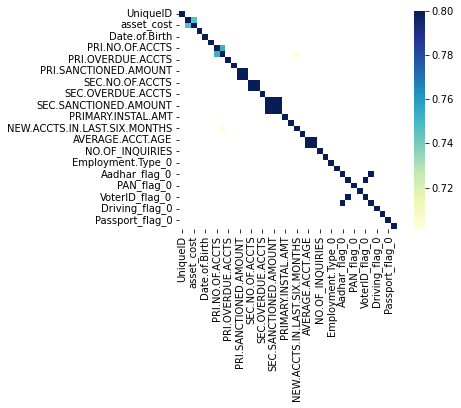

In [23]:
#Draw Correlation Matrix to check correlation
import seaborn as sns
corr = data.corr()
sns.heatmap(corr[corr > 0.6], vmax=.8, square=True,cmap = 'YlGnBu')
corr[corr > 0.6].dropna(axis = 1,how = 'all')

In [24]:
#Drop PRI.ACTIVE.ACCTS, disbursed_amount
data = data.drop(['PRI.ACTIVE.ACCTS','disbursed_amount'],axis=1)
data.head()

,UniqueID,asset_cost,ltv,Date.of.Birth,PERFORM_CNS.SCORE,PRI.NO.OF.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,...,Aadhar_flag_0,Aadhar_flag_1,PAN_flag_0,PAN_flag_1,VoterID_flag_0,VoterID_flag_1,Driving_flag_0,Driving_flag_1,Passport_flag_0,Passport_flag_1
0,555299,75208,57.17,54,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,1,0
1,611197,87691,74.12,35,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,1,0
2,433544,98158,76.31,28,836,1,0,0,0,0,...,1,0,1,0,0,1,1,0,1,0
3,648093,63841,88.97,48,17,1,0,56800,56800,56800,...,0,1,1,0,1,0,1,0,1,0
4,461365,66542,83.41,43,738,2,0,8545,25000,25000,...,0,1,1,0,1,0,1,0,1,0


In [25]:
#Finally need to drop UniqueID
#Need to Seperate train and test first
position = np.where(data.UniqueID == dataTest.UniqueID[0])[0][0] #Find location of first test using UniqueID
dataTR = data.iloc[:position,:]
dataTE = data.iloc[position:,:]

dataTR = dataTR.drop(['UniqueID'],axis=1)
dataTE = dataTE.drop(['UniqueID','loan_default'],axis=1)

In [26]:
#Check if data contains none value
print('The training set has null = ',dataTR.isnull().sum(axis = 0).sum())
print('The training set has null = ',dataTE.isnull().sum(axis = 0).sum())

The training set has null =  0
The training set has null =  0


## Data Visualization and Processing

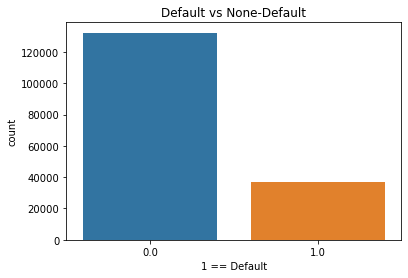

In [27]:
#Check if data is imbalanced
sns.countplot(x = 'loan_default',data = dataTR)
plt.title('Default vs None-Default')
plt.xlabel('1 == Default')
plt.show()

In [28]:
#Since the data is very imbalanced, need to resample the data, choose to use undersampling in this case since the data size is large enough.
from sklearn.utils import resample
#Get sample of not default part
dataDefault = dataTR[dataTR.loan_default == 1]
dataNotDefault = dataTR[dataTR.loan_default == 0]
#Under Sample the Not default
dataNDSampled = resample(dataNotDefault,
                          replace = True,
                          n_samples = len(dataDefault),
                          random_state = 100)
dataNew = pd.concat([dataDefault,dataNDSampled]) #New balanced data
dataNew = dataNew.reset_index(drop = True) #Reset index
len(dataNew[dataNew.loan_default == 1]),len(dataNew[dataNew.loan_default == 0]) #Check if the lengths are match


(36890, 36890)

## Train-test Split and Standardization

In [29]:
y = dataNew.loan_default
X = dataNew.loc[:,dataNew.columns != 'loan_default']
sc = StandardScaler()

#Need to do standard scalar transform for none dummy variables
noDummyCol = dataTR.columns[:22]
def standardization(df,col):
  dfnew = copy.deepcopy(df)
  for i in col:
    dfnew[i] = pd.DataFrame(sc.fit_transform(pd.DataFrame(df[i])))
  return dfnew

X = standardization(X,noDummyCol)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

In [30]:
#Do the same thing for Real Test Dataset
dataTE = dataTE.reset_index(drop = True)
dataTE_New = standardization(dataTE,noDummyCol)
dataTE_New

,asset_cost,ltv,Date.of.Birth,PERFORM_CNS.SCORE,PRI.NO.OF.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,...,Aadhar_flag_0,Aadhar_flag_1,PAN_flag_0,PAN_flag_1,VoterID_flag_0,VoterID_flag_1,Driving_flag_0,Driving_flag_1,Passport_flag_0,Passport_flag_1
0,-0.098726,0.449541,-0.255740,0.016837,0.294149,1.505968,-0.180757,-0.188149,-0.186714,-0.098373,...,0,1,1,0,1,0,1,0,1,0
1,-0.219137,-0.188586,0.775716,-0.867704,-0.479707,-0.288630,-0.180757,-0.188149,-0.186714,-0.098373,...,0,1,1,0,1,0,1,0,1,0
2,-0.436634,-0.848508,0.259988,-0.867704,-0.479707,-0.288630,-0.180757,-0.188149,-0.186714,-0.098373,...,1,0,1,0,0,1,1,0,1,0
3,1.146269,0.889779,0.569425,-0.867704,-0.479707,-0.288630,-0.180757,-0.188149,-0.186714,-0.098373,...,0,1,1,0,1,0,1,0,1,0
4,-0.716038,0.447798,-0.358886,1.225710,0.100685,-0.288630,-0.155769,-0.151377,-0.150167,-0.098373,...,0,1,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56302,-0.891111,0.645687,0.053697,-0.867704,-0.479707,-0.288630,-0.180757,-0.188149,-0.186714,-0.098373,...,0,1,1,0,1,0,1,0,1,0
56303,-0.452111,0.727632,0.775716,-0.867704,-0.479707,-0.288630,-0.180757,-0.188149,-0.186714,-0.098373,...,0,1,1,0,1,0,1,0,1,0
56304,-0.179842,1.315198,0.363134,0.016837,0.294149,1.505968,-0.156446,-0.158327,-0.157074,-0.098373,...,0,1,1,0,1,0,1,0,1,0
56305,-0.431530,0.558511,0.466279,0.016837,0.874542,3.300565,0.066992,0.093923,0.141910,-0.098373,...,0,1,1,0,1,0,1,0,1,0


In [31]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

### Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression
logis = LogisticRegression() 
logis.fit(X_train,y_train)
y_predict_logis = logis.predict(X_test)


/Users/zhangbolin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[5024 4196]
 [3377 5848]]
Accuracy of model  0.5894280292762266
              precision    recall  f1-score   support

         0.0   0.598024  0.544902  0.570229      9220
         1.0   0.582238  0.633930  0.606985      9225

    accuracy                       0.589428     18445
   macro avg   0.590131  0.589416  0.588607     18445
weighted avg   0.590129  0.589428  0.588612     18445



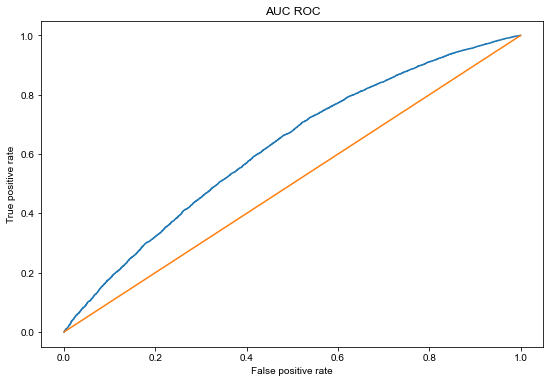

In [33]:
print(confusion_matrix(y_test, y_predict_logis))
print("Accuracy of model ",accuracy_score(y_test, y_predict_logis))
print(classification_report(y_test, y_predict_logis, digits=6))

#Part for AUC
y_predict_logis_probs = logis.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_predict_logis_probs, drop_intermediate=True)

f, ax = plt.subplots(figsize=(9, 6))
_ = plt.plot(fpr, tpr, [0,1], [0, 1])
_ = plt.title('AUC ROC')
_ = plt.xlabel('False positive rate')
_ = plt.ylabel('True positive rate')
plt.style.use('seaborn')

plt.savefig('auc_roc.png', dpi=600)

In [34]:
X_train.columns

Index(['asset_cost', 'ltv', 'Date.of.Birth', 'PERFORM_CNS.SCORE',
       'PRI.NO.OF.ACCTS', 'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE',
       'PRI.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS',
       'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE',
       'SEC.SANCTIONED.AMOUNT', 'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT',
       'SEC.INSTAL.AMT', 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
       'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'AVERAGE.ACCT.AGE',
       'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES', 'Employment.Type_0',
       'Employment.Type_1', 'Aadhar_flag_0', 'Aadhar_flag_1', 'PAN_flag_0',
       'PAN_flag_1', 'VoterID_flag_0', 'VoterID_flag_1', 'Driving_flag_0',
       'Driving_flag_1', 'Passport_flag_0', 'Passport_flag_1'],
      dtype='object')

feature: asset_cost Score: 0.11515456723982885
feature: ltv Score: 0.32078915498941496
feature: Date.of.Birth Score: -0.09586279809756369
feature: PERFORM_CNS.SCORE Score: -0.10900844959412428
feature: PRI.NO.OF.ACCTS Score: -0.025093056642643892
feature: PRI.OVERDUE.ACCTS Score: 0.16383255773760083
feature: PRI.CURRENT.BALANCE Score: -0.07788265334778534
feature: PRI.SANCTIONED.AMOUNT Score: -0.23451386546150427
feature: PRI.DISBURSED.AMOUNT Score: 0.24401927270409612
feature: SEC.NO.OF.ACCTS Score: -0.018716576660244053
feature: SEC.ACTIVE.ACCTS Score: 0.042064533766865475
feature: SEC.OVERDUE.ACCTS Score: 0.01168734649833972
feature: SEC.CURRENT.BALANCE Score: 0.07555075881773493
feature: SEC.SANCTIONED.AMOUNT Score: -0.16377192762646237
feature: SEC.DISBURSED.AMOUNT Score: 0.06518245375916877
feature: PRIMARY.INSTAL.AMT Score: -0.0031607041926082803
feature: SEC.INSTAL.AMT Score: 0.0041266471958574715
feature: NEW.ACCTS.IN.LAST.SIX.MONTHS Score: -0.05424627698343128
feature: DELINQ

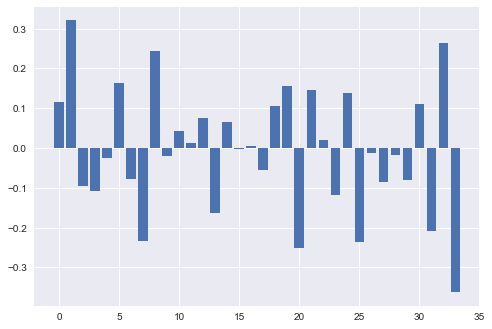

In [35]:
importance = logis.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
 print('feature:', X_train.columns.values[i], 'Score:', v)
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

### Naive Bayes

In [36]:
#Try Naive Bayes
from sklearn.naive_bayes import GaussianNB
naive = GaussianNB()
naive.fit(X_train, y_train)
y_pred_naive = naive.predict(X_test)

[[3997 5223]
 [2764 6461]]
Accuracy of model  0.5669829222011386
              precision    recall  f1-score   support

         0.0   0.591185  0.433514  0.500219      9220
         1.0   0.552978  0.700379  0.618011      9225

    accuracy                       0.566983     18445
   macro avg   0.572082  0.566947  0.559115     18445
weighted avg   0.572076  0.566983  0.559131     18445



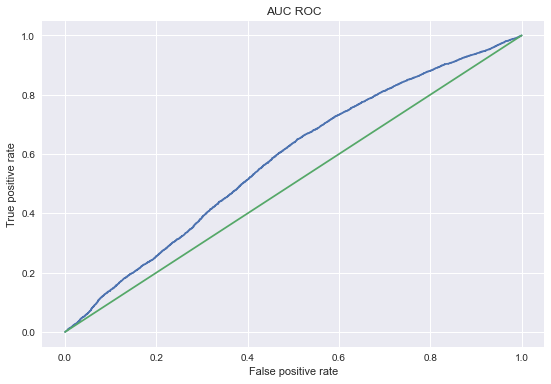

In [37]:
print(confusion_matrix(y_test, y_pred_naive))
print("Accuracy of model ",accuracy_score(y_test, y_pred_naive))
print(classification_report(y_test, y_pred_naive, digits=6))

#Part for AUC
y_pred_naive_probs = naive.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_naive_probs, drop_intermediate=True)

f, ax = plt.subplots(figsize=(9, 6))
_ = plt.plot(fpr, tpr, [0,1], [0, 1])
_ = plt.title('AUC ROC')
_ = plt.xlabel('False positive rate')
_ = plt.ylabel('True positive rate')
plt.style.use('seaborn')

plt.savefig('auc_roc.png', dpi=600)

In [38]:
from sklearn.inspection import permutation_importance
imps = permutation_importance(naive, X_test, y_test)
importances = imps.importances_mean
std = imps.importances_std
indices = np.argsort(importances)[::-1]
features = X_train.columns.values


# Print the feature ranking
print("Feature ranking:")
for f in range(X_test.shape[1]):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
1. ltv (0.023302)
2. PERFORM_CNS.SCORE (0.012068)
3. NO.OF_INQUIRIES (0.007156)
4. PRI.OVERDUE.ACCTS (0.006050)
5. VoterID_flag_1 (0.005053)
6. VoterID_flag_0 (0.005053)
7. Aadhar_flag_0 (0.004999)
8. Aadhar_flag_1 (0.004999)
9. DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS (0.004608)
10. CREDIT.HISTORY.LENGTH (0.004283)
11. Date.of.Birth (0.004066)
12. NEW.ACCTS.IN.LAST.SIX.MONTHS (0.003535)
13. PRI.CURRENT.BALANCE (0.001822)
14. SEC.NO.OF.ACCTS (0.001019)
15. Driving_flag_0 (0.000943)
16. Driving_flag_1 (0.000943)
17. SEC.ACTIVE.ACCTS (0.000922)
18. Employment.Type_1 (0.000596)
19. Employment.Type_0 (0.000596)
20. asset_cost (0.000542)
21. SEC.SANCTIONED.AMOUNT (0.000520)
22. SEC.DISBURSED.AMOUNT (0.000488)
23. PRI.NO.OF.ACCTS (0.000336)
24. PAN_flag_0 (0.000293)
25. PAN_flag_1 (0.000293)
26. PRIMARY.INSTAL.AMT (0.000228)
27. Passport_flag_1 (0.000217)
28. Passport_flag_0 (0.000217)
29. SEC.CURRENT.BALANCE (0.000184)
30. SEC.INSTAL.AMT (0.000098)
31. SEC.OVERDUE.ACCTS (-0.0000

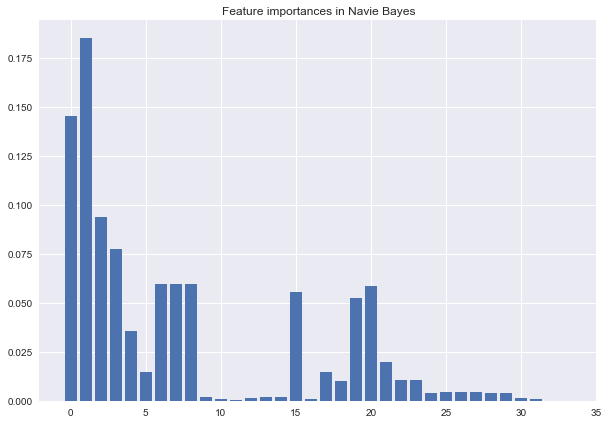

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   3.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=70; total time=   3.8s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=70; total time=   8.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=70; total time=   8.9s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=70; total time=   5.4s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   9.7s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  10.4s
[CV] END bootstrap=True, max_depth=10, max_featu

In [45]:
plt.figure(figsize=(10, 7))
plt.title("Feature importances in Navie Bayes")
plt.bar(range(X_test.shape[1]), importances)
plt.show()

### Random Forest

In [39]:
#Parameters Tuning
from sklearn.ensemble import RandomForestClassifier
#Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 70, num = 2)]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 30, num = 2)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfclassifier = RandomForestClassifier()
# Random search of parameters, using 5 fold cross validation, 
# search across 200 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rfclassifier, param_distributions = random_grid, n_iter = 200, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

rf_random.best_params_

{'n_estimators': [50, 70], 'max_features': ['auto'], 'max_depth': [10, 30, None], 'min_samples_split': [2], 'min_samples_leaf': [1], 'bootstrap': [True, False]}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/zhangbolin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 12 is smaller than n_iter=200. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'n_estimators': 70,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 30,
 'bootstrap': False}

In [40]:
from sklearn.ensemble import RandomForestClassifier
randomforest = RandomForestClassifier(n_estimators=142,min_samples_split = 5,min_samples_leaf = 4,max_features = 'auto',\
                                  max_depth = 90, bootstrap = True, random_state=100)

randomforest.fit(X_train, y_train)
y_pred_rf = randomforest.predict(X_test)

[[5459 3761]
 [3285 5940]]
Accuracy of model  0.6179994578476552
              precision    recall  f1-score   support

         0.0   0.624314  0.592082  0.607771      9220
         1.0   0.612308  0.643902  0.627708      9225

    accuracy                       0.617999     18445
   macro avg   0.618311  0.617992  0.617740     18445
weighted avg   0.618309  0.617999  0.617742     18445



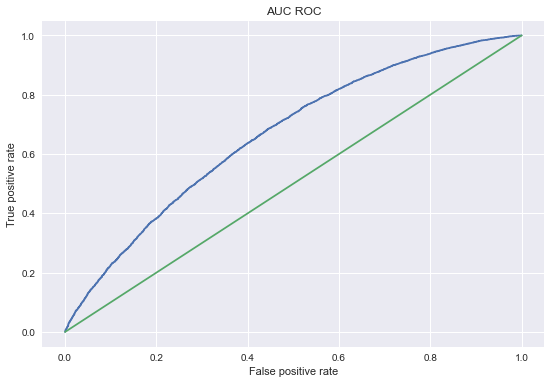

In [41]:
print(confusion_matrix(y_test, y_pred_rf))
print("Accuracy of model ",accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, digits=6))

#Part for AUC
y_pred_rf_probs = randomforest.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf_probs, drop_intermediate=True)

f, ax = plt.subplots(figsize=(9, 6))
_ = plt.plot(fpr, tpr, [0,1], [0, 1])
_ = plt.title('AUC ROC')
_ = plt.xlabel('False positive rate')
_ = plt.ylabel('True positive rate')
plt.style.use('seaborn')

plt.savefig('auc_roc.png', dpi=600)

feature: asset_cost Score: 0.11515456723982885
feature: ltv Score: 0.32078915498941496
feature: Date.of.Birth Score: -0.09586279809756369
feature: PERFORM_CNS.SCORE Score: -0.10900844959412428
feature: PRI.NO.OF.ACCTS Score: -0.025093056642643892
feature: PRI.OVERDUE.ACCTS Score: 0.16383255773760083
feature: PRI.CURRENT.BALANCE Score: -0.07788265334778534
feature: PRI.SANCTIONED.AMOUNT Score: -0.23451386546150427
feature: PRI.DISBURSED.AMOUNT Score: 0.24401927270409612
feature: SEC.NO.OF.ACCTS Score: -0.018716576660244053
feature: SEC.ACTIVE.ACCTS Score: 0.042064533766865475
feature: SEC.OVERDUE.ACCTS Score: 0.01168734649833972
feature: SEC.CURRENT.BALANCE Score: 0.07555075881773493
feature: SEC.SANCTIONED.AMOUNT Score: -0.16377192762646237
feature: SEC.DISBURSED.AMOUNT Score: 0.06518245375916877
feature: PRIMARY.INSTAL.AMT Score: -0.0031607041926082803
feature: SEC.INSTAL.AMT Score: 0.0041266471958574715
feature: NEW.ACCTS.IN.LAST.SIX.MONTHS Score: -0.05424627698343128
feature: DELINQ

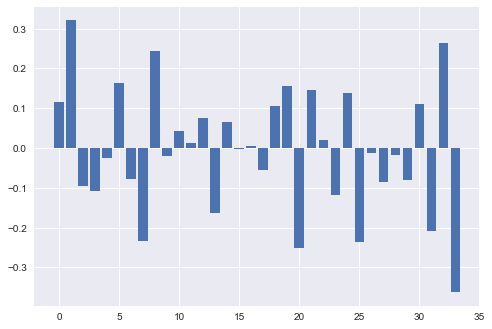

In [42]:
importances = randomforest.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print('feature:', X_train.columns.values[i], 'Score:', v)
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

## Check Recall-Precision Table to find optimal thresholds

In [43]:
from sklearn.metrics import precision_recall_curve
rf_pred_prob = randomforest.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test,rf_pred_prob)
'''
fscore = (2 * precision * recall) / (precision + recall)
fscore = pd.Series(fscore).dropna()
index = np.argmax(fscore)

thresholds = thresholds[index]

y_pred_xgb_Opt = (xgb_pred_prob >= thresholds).astype('int')
print('The F1 score with optimal threshold is:',f1_score(y_test,y_pred_xgb_Opt))
'''

"\nfscore = (2 * precision * recall) / (precision + recall)\nfscore = pd.Series(fscore).dropna()\nindex = np.argmax(fscore)\n\nthresholds = thresholds[index]\n\ny_pred_xgb_Opt = (xgb_pred_prob >= thresholds).astype('int')\nprint('The F1 score with optimal threshold is:',f1_score(y_test,y_pred_xgb_Opt))\n"

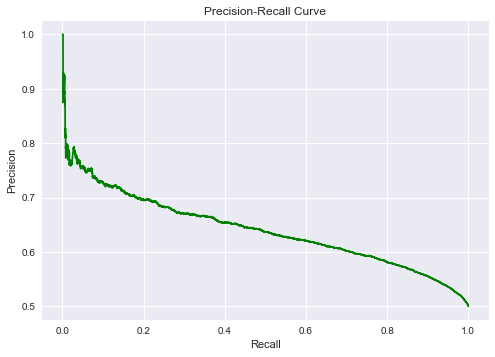

In [44]:
#Visualiation of precision-recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='green')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()


# Findings

### From logistic regression, feature itv has the largest positive correlation with loan default and feature Passport_flag_1 has the largest negative correlation with loan default. For Naive bayes, we can obtain nearly the same result that feature itv has the largest relativity with loan default. And finally, from random forest, we get the same results again.
### So, from F1-score, all of these three models accurately predict the loan default rate through customer information.

# Conclusion

### We can see that among those models, even if all models give us the same results, form F1-score, Random Forest gives the best result after calibrating the parameters. We get the same conclusions with our references.

### In the future, maybe this model can be used to predict the relationship between the value of a stock and market information, because we can understand the correlation between market information and stock value. And Predict the value of a stock by constructing feature labels for market information and training it.